In [7]:
import shap
import tqdm
import numpy as np
import torch.nn.functional as F

display_images = shap.datasets.imagenet50()[0].astype('uint8') # shape = (50, 224, 224, 3)

In [3]:
import torch 
from torchvision import models

model = models.resnet18(pretrained=True)
model = model.eval() # turns off training mode for batch 

/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
import torchvision.transforms as transforms

# Image pre-processing, expects single image of size (224, 224, 3)
model_transforms = transforms.Compose([
transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
# # Apply pre-processing and make predictions
# images = torch.stack([model_transforms(img) for img in display_images])
# pred = model(images).softmax(dim=1)

(224, 224, 3)

## Occlusion

(a)

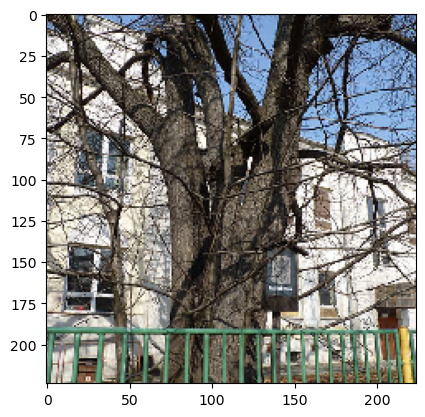

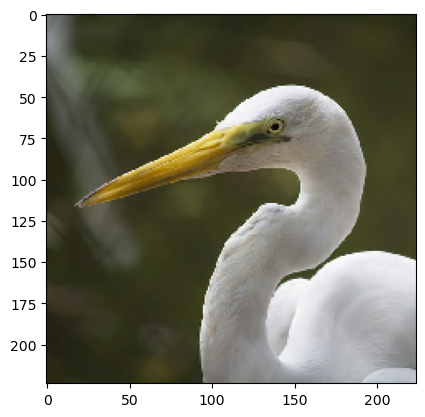

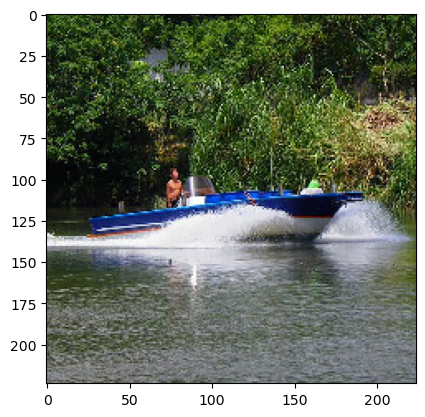

In [4]:
import matplotlib.pyplot as plt

for i in range(3):
    # Generate plot
    plt.figure() 
    plt.imshow(display_images[i])
    # plt.savefig(f"q2_a_{i}.png")
    plt.show()

(b)

In [5]:
# Apply pre-processing and make predictions
images = torch.stack([model_transforms(img) for img in display_images[:3]])
pred = model(images).softmax(dim=1)
pred_class_idx = torch.argmax(pred, dim=1)
pred_class_idx

tensor([829, 132, 814])

829: streetcar, tram, tramcar, trolley, trolley car

132: American egret, great white heron, Egretta albus

814: speedboat

(c) Feature importance value

In [24]:
import tqdm

def occlusion(imgs, model, target_labels, baseline, superpixel_size=8):
    ''' Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224) model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,) baseline: baseline value for occluded features
    superpixel_size: width/height of superpixels
    Returns:
    importance: occlusion scores, size = (batch, 224, 224)
    '''
    
    superpixels = np.zeros((superpixel_size, superpixel_size, 3))
    importance = np.zeros((imgs.shape[0], imgs.shape[2], imgs.shape[3]))
    
#     def occlusion_sensitivity(
#     model, images, ids, mean=None, patch=35, stride=1, n_batches=128
# ):

    # torch.set_grad_enabled(False)
    # model.eval()
    # mean = mean if mean else 0
    
    pad_H, pad_W = superpixel_size // 2, superpixel_size // 2
    # n_batches = imgs.shape[0]

    # Padded image
    images = F.pad(imgs, (pad_W, pad_W, pad_H, pad_H), value=0)
    B, _, H, W = images.shape
    new_H = (H - superpixel_size) + 1
    new_W = (W - superpixel_size) + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - superpixel_size:
        grid_w = 0
        while grid_w <= W - superpixel_size:
            grid_w += 1
            anchors.append((grid_h, grid_w))
        grid_h += 1

    # Baseline score without occlusion
    # baseline = model(images).detach().gather(1, ids)

    # # Compute per-pixel logits
    # scoremaps = []
    # for i in tqdm(range(0, len(anchors), n_batches), leave=False):
    #     batch_images = []
    #     batch_ids = []
    #     for grid_h, grid_w in anchors[i : i + n_batches]:
    #         images_ = images.clone()
    #         images_[..., grid_h : grid_h + superpixel_size, grid_w : grid_w + superpixel_size] = 0
    #         batch_images.append(images_)
    #         # batch_ids.append(ids)
    #     batch_images = torch.cat(batch_images, dim=0)
    #     # batch_ids = torch.cat(batch_ids, dim=0)
    #     scores = model(batch_images).detach().gather(1, batch_ids) #????
    #     scoremaps += list(torch.split(scores, B))
    
    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm.tqdm(range(0, len(anchors), 1), leave=False):
        batch_images = []
        grid_h, grid_w = anchors[i]
        # for grid_h, grid_w in anchors[i : i + 1]:
        images_ = images.clone()
        images_[..., grid_h : grid_h + superpixel_size, grid_w : grid_w + superpixel_size] = 0
        batch_images = images_ # batch_images = torch.cat(batch_images, dim=0)
        scores = model(batch_images).softmax(dim=1).detach() 
        # scores.shape (batchsize, num_classes 1000)
        # scores = scores.gather(1, target_labels)
        logits = scores[..., target_labels]
        scoremaps += list(torch.split(logits, B))
        

    print(torch.cat(scoremaps, dim=1).shape)
    raise ValueError
    importancemap = torch.cat(scoremaps, dim=1) - baseline
    importancemap = importancemap.view(B, new_H, new_W)

    return importancemap


# Generate black image, then apply pre-processing
baseline = model_transforms(np.zeros((224, 224, 3), np.uint8))
# baseline = model(baseline).softmax(dim=1)

for i in range(3):
    # Apply pre-processing and make predictions
    # image = torch.stack([model_transforms(img) for img in display_images[i]])
    image = torch.stack([model_transforms(display_images[i])])
    single_importance = occlusion(image, model, pred_class_idx[i], baseline)
    
    raise NotImplementedError
    
    single_importance = single_importance.squeeze().cpu().numpy() 
    # Generate plot
    plt.figure()
    m = single_importance.abs().max()
    plt.imshow(single_importance, vmin=-m, vmax=m, cmap='seismic') # specify min/max value plt.show()


  0%|          | 0/50625 [00:00<?, ?it/s]

KeyboardInterrupt: 

(d) For the first of the three images, compare the results when using superpixels of size 4 × 4, 8 × 8 and 16 × 16. Plot the results side-by-side.